In [1]:
!pip install japanize-matplotlib | tail -n 1
!pip install torchviz | tail -1
!pip install torchinfo | tail -n 1
w = !apt install tree
print('w[-2]', w[-2])

import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib

plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = (6,6)
plt.rcParams['axes.grid'] = True

import torch
from torch import tensor
import torch.nn as nn
import torch.optim as optim
from torchviz import make_dot
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets
from tqdm.notebook import tqdm
from torchinfo import summary

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

def eval_loss(loader, device, net, criterion):
    images, labels = next(iter(loader))
    inputs = images.to(device)
    labels = labels.to(device)
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    return loss

def fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history):
    base_epochs = len(history)

    for epoch in range(base_epochs, num_epochs+base_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        net.train()
        count = 0

        for inputs, labels in tqdm(train_loader):
            count += len(labels)
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            train_loss += loss.item()
            loss.backward()
            optimizer.step()
            predicted = torch.max(outputs, 1)[1]
            train_acc += (predicted == labels).sum().item()
            avg_train_loss = train_loss / count
            avg_train_acc = train_acc / count

        net.eval()
        count = 0

        for inputs, labels in test_loader:
            count += len(labels)
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            predicted = torch.max(outputs, 1)[1]
            val_acc += (predicted == labels).sum().item()
            avg_val_loss = val_loss / count
            avg_val_acc = val_acc / count

        print(f'Epoch [{(epoch+1)}/{num_epochs+base_epochs}], loss: {avg_train_loss:.5f} acc: {avg_train_acc:.5f} val_loss: {avg_val_loss:.5f}, val_acc: {avg_val_acc:.5f}')
        item = np.array([epoch+1, avg_train_loss, avg_train_acc, avg_val_loss, avg_val_acc])
        history = np.vstack((history, item))
    return history

def evaluate_history(history):
    print(f'初期状態: 損失: {history[0,3]:.5f} 精度: {history[0,4]:.5f}')
    print(f'最終状態: 損失: {history[-1,3]:.5f} 精度: {history[-1,4]:.5f}' )
    num_epochs = len(history)
    if num_epochs < 10:
        unit = 1
    else:
        unit = num_epochs / 10
    plt.figure(figsize=(9,8))
    plt.plot(history[:,0], history[:,1], 'b', label='訓練')
    plt.plot(history[:,0], history[:,3], 'k', label='検証')
    plt.xticks(np.arange(0,num_epochs+1, unit))
    plt.xlabel('繰り返し回数')
    plt.ylabel('損失')
    plt.title('学習曲線(損失)')
    plt.legend()
    plt.show()
    plt.figure(figsize=(9,8))
    plt.plot(history[:,0], history[:,2], 'b', label='訓練')
    plt.plot(history[:,0], history[:,4], 'k', label='検証')
    plt.xticks(np.arange(0,num_epochs+1,unit))
    plt.xlabel('繰り返し回数')
    plt.ylabel('精度')
    plt.title('学習曲線(精度)')
    plt.legend()
    plt.show()

def show_images_labels(loader, classes, net, device):
    images, labels = next(iter(loader))
    n_size = min(len(images), 50)
    if net is not None:
        inputs = images.to(device)
        labels = labels.to(device)
        outputs = net(inputs)
        predicted = torch.max(outputs,1)[1]
    plt.figure(figsize=(20, 15))

    for i in range(n_size):
        ax = plt.subplot(5, 10, i + 1)
        label_name = classes[labels[i]]
        if net is not None:
            predicted_name = classes[predicted[i]]
            if label_name == predicted_name:
                c = 'k'
            else:
                c = 'b'
            ax.set_title(label_name + ':' + predicted_name, c=c, fontsize=20)
        else:
            ax.set_title(label_name, fontsize=20)
        image_np = images[i].numpy().copy()
        img = np.transpose(image_np, (1, 2, 0))
        img = (img + 1)/2
        plt.imshow(img)
        ax.set_axis_off()
    plt.show()

def torch_seed(seed=123):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True


w[-2] Setting up tree (2.0.2-1) ...
cuda:0


In [2]:
import shutil
import urllib.request

url = 'https://download.pytorch.org/tutorial/'
fname = 'hymenoptera_data.zip'
urllib.request.urlretrieve(url + fname, fname)
shutil.unpack_archive(fname, './')

In [3]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

test_transform = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224),
                                      transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_transform = transforms.Compose([transforms.RandomResizedCrop(224), transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                     transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False)])


In [4]:
data_dir = 'hymenoptera_data'
import os
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'val')
print(train_dir, test_dir)
classes = ['ants', 'bees']

hymenoptera_data/train hymenoptera_data/val


(768, 512) 0
<class 'PIL.Image.Image'>
(512, 768, 3)


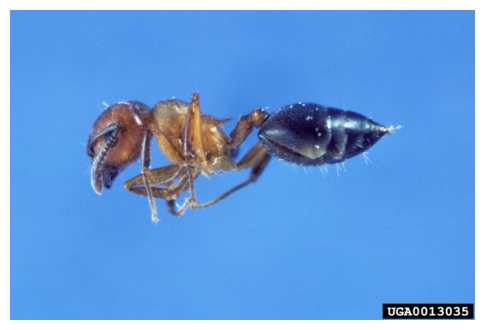

In [5]:
dataset = datasets.ImageFolder(train_dir)
image, label = dataset[0]
print(image.size, label)
print(type(image))
ary = np.array(image)
print(ary.shape)
plt.imshow(image)
plt.axis('off')
plt.show()

In [6]:
train_data = datasets.ImageFolder(train_dir, transform=train_transform)
train_data2 = datasets.ImageFolder(train_dir, transform=test_transform)

test_data = datasets.ImageFolder(test_dir, transform=test_transform)

print(f'訓練データ：{len(train_data)}件')
print(f'検証データ：{len(test_data)}件')


訓練データ：244件
検証データ：153件


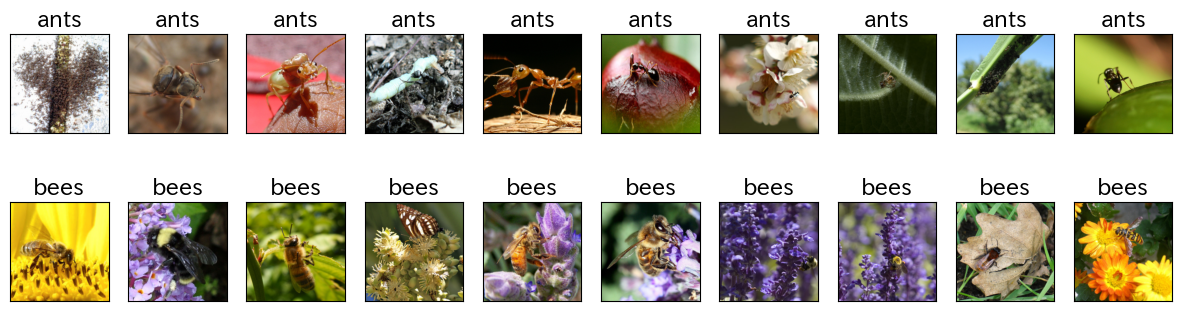

In [7]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(15,4))
for i in range(10):
    ax = plt.subplot(2, 10, i+1)
    image, label = test_data[i]
    img = np.transpose(image.numpy(), (1, 2, 0))
    img = (img + 1) / 2
    plt.imshow(img)
    ax.set_title(classes[label])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, 10, i+11)
    image, label = test_data[-i-1]
    img = np.transpose(image.numpy(), (1, 2, 0))
    img = (img + 1) / 2
    plt.imshow(img)
    ax.set_title(classes[label])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()


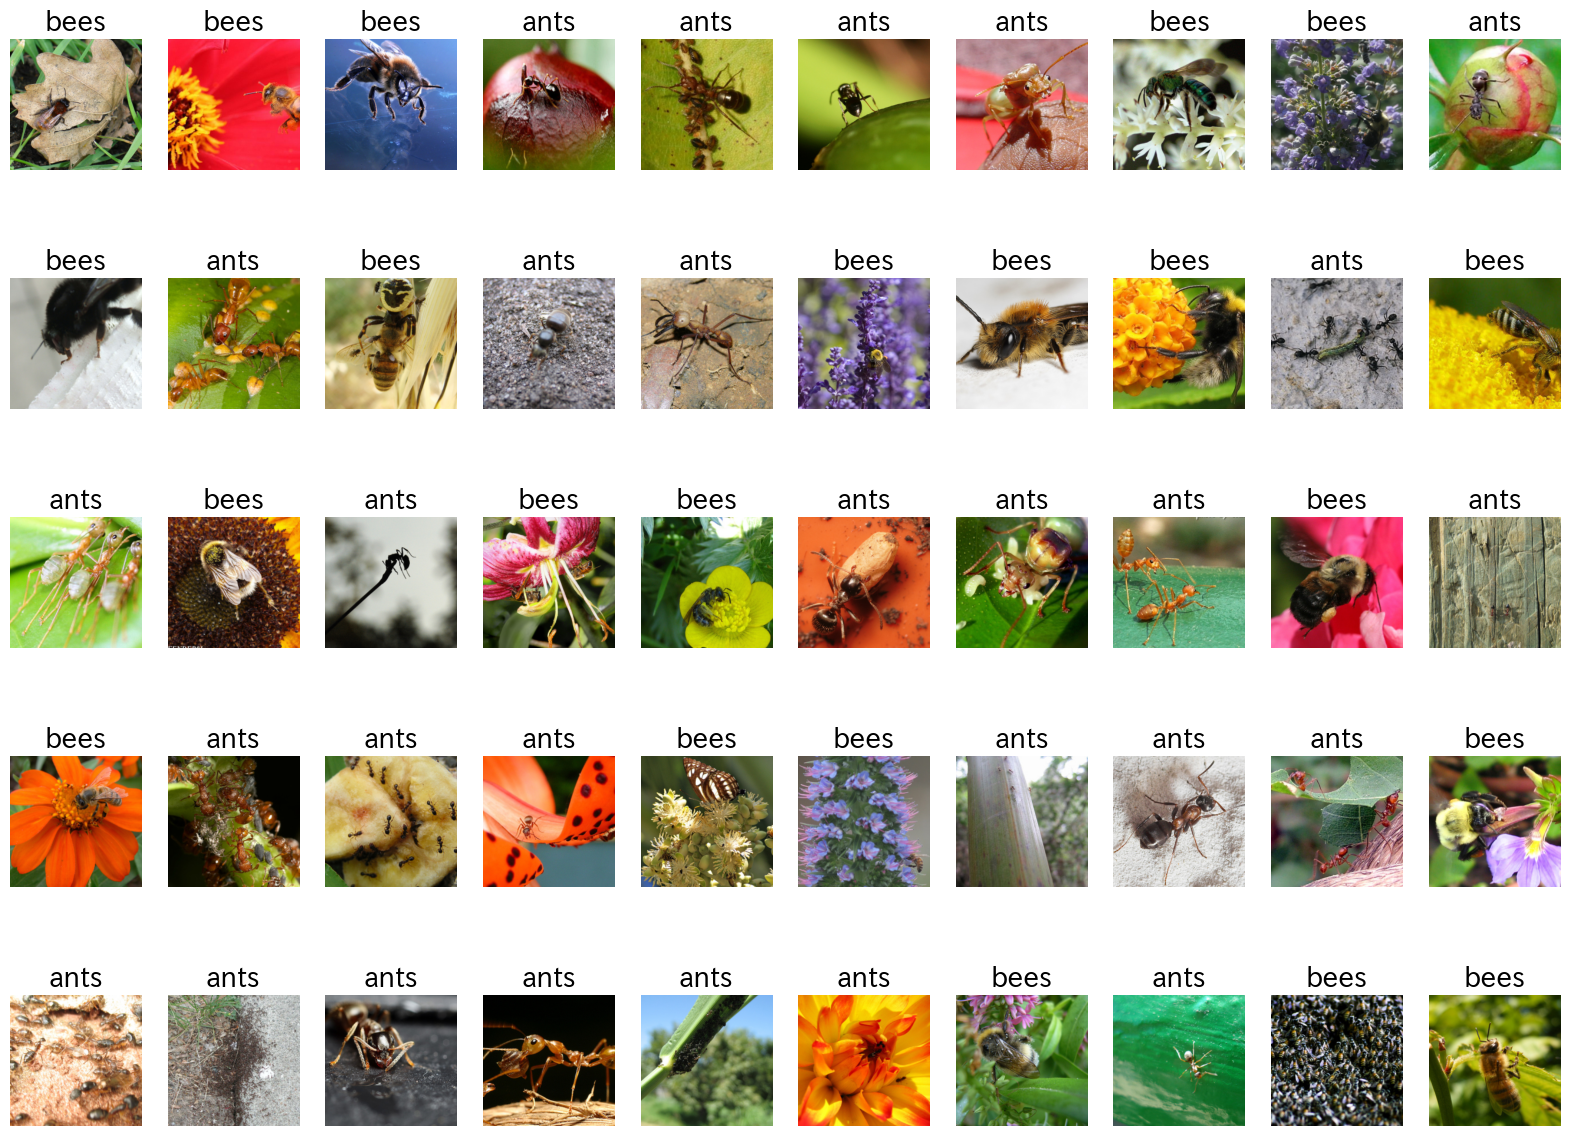

In [8]:
batch_size = 10

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

train_loader2 = DataLoader(train_data2, batch_size=50, shuffle=True)
test_loader2 = DataLoader(test_data, batch_size=50, shuffle=True)

torch_seed()
show_images_labels(test_loader2, classes, None, None)

In [9]:
from torchvision import models
net = models.vgg19_bn(pretrained=True)

print(net)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth


100%|██████████| 548M/548M [00:03<00:00, 168MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [10]:
torch_seed()

in_features = net.classifier[6].in_features
net.classifier[6] = nn.Linear(in_features, 2)

net.avgpool = nn.Identity()

net = net.to(device)

summary(net, (10,3,224,224))

import torchsummary
torchsummary.summary(net, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,928
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
         MaxPool2d-7         [-1, 64, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]          73,856
       BatchNorm2d-9        [-1, 128, 112, 112]             256
             ReLU-10        [-1, 128, 112, 112]               0
           Conv2d-11        [-1, 128, 112, 112]         147,584
      BatchNorm2d-12        [-1, 128, 112, 112]             256
             ReLU-13        [-1, 128, 112, 112]               0
        MaxPool2d-14          [-1, 128,

In [11]:
lr = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)
history = np.zeros((0, 5))

In [12]:
num_epochs = 5
history = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history)
torch.save(net.state_dict(), 'vgg19_bn_finetuning.pth')

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [1/5], loss: 0.04568 acc: 0.77869 val_loss: 0.01505, val_acc: 0.94118


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [2/5], loss: 0.02253 acc: 0.90574 val_loss: 0.01630, val_acc: 0.95425


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [3/5], loss: 0.03771 acc: 0.87295 val_loss: 0.02111, val_acc: 0.93464


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [4/5], loss: 0.02279 acc: 0.92213 val_loss: 0.01786, val_acc: 0.92157


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [5/5], loss: 0.01902 acc: 0.92623 val_loss: 0.01524, val_acc: 0.94118


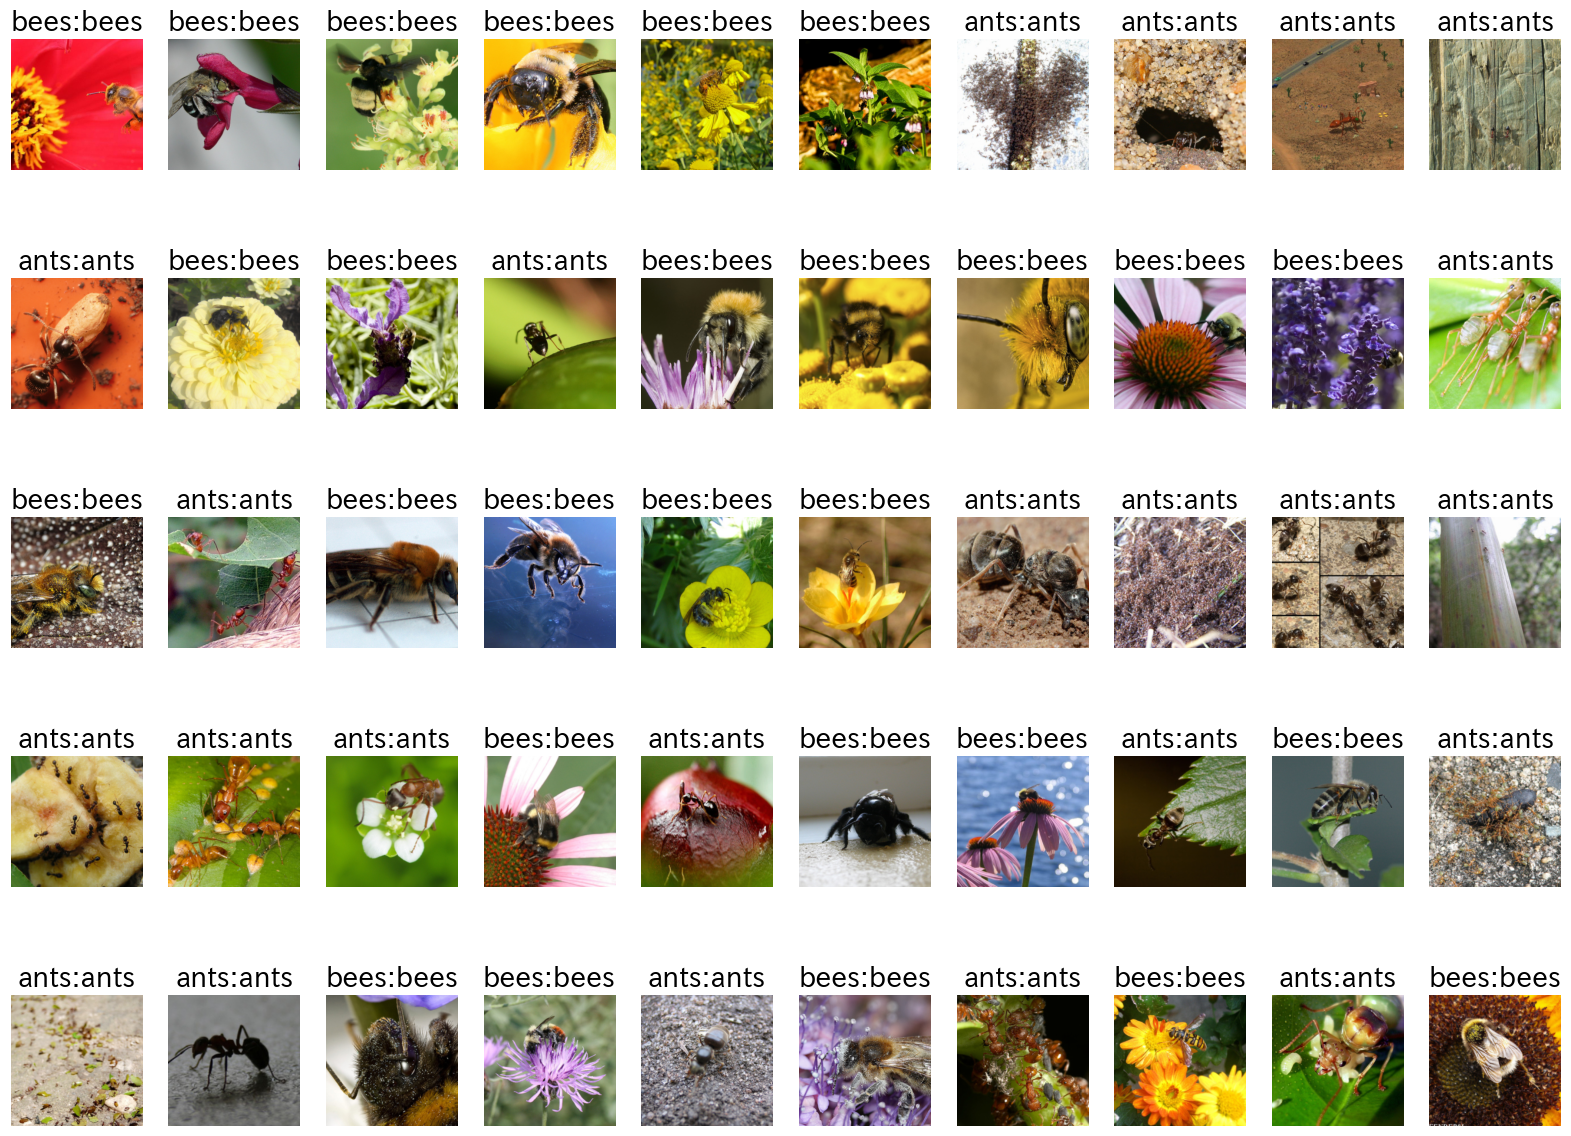

In [13]:
show_images_labels(test_loader2, classes, net, device)